Original Author : @AustinRochford 
A Dockerfile that will produce a container with all the dependencies necessary to run this notebook is available [here](https://github.com/AustinRochford/notebooks).

In [5]:
%matplotlib inline

In [6]:
from warnings import filterwarnings

In [7]:
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from statsmodels.datasets import get_rdataset

In [8]:
# configure pyplot for readability when rendered as a slideshow and projected
plt.rc('figure', figsize=(8, 6))

LABELSIZE = 14
plt.rc('axes', labelsize=LABELSIZE)
plt.rc('axes', titlesize=LABELSIZE)
plt.rc('figure', titlesize=LABELSIZE)
plt.rc('legend', fontsize=LABELSIZE)
plt.rc('xtick', labelsize=LABELSIZE)
plt.rc('ytick', labelsize=LABELSIZE)

In [9]:
filterwarnings('ignore', 'findfont')

In [10]:
blue, green, red, purple, gold, teal = sns.color_palette(n_colors=6)

pct_formatter = StrMethodFormatter('{x:.1%}')

In [11]:
SEED = 54902 # from random.org, for reproducibility

np.random.seed(SEED)

# Introduction à l'Inférence Bayesienne avec Python and PyMC3
Club de lecture Septembre 2018
##### Alexis Fortin-Côté

<center><img src='https://ichef.bbci.co.uk/images/ic/896x504/p04pxlg4.jpg' width="90%"></center>

### How often have I said to you that when you have eliminated the impossible, whatever remains, however improbable, must be the truth?
##### -Sherlock Holmes, The Sign of the Four Chap. 6, p. 111,  (1890)

## A partir d'une présentation de [@AustinRochford](https://twitter.com/AustinRochford)
[original notebook](https://gist.github.com/AustinRochford/d83ecc6acd17a632a2b9df788386540b)

# Inférence Bayésienne vs Analyses fréquentistes

<table align="center">
    <centering>
    <tr>
        <td>
            <span><img src="http://austinrochford.com/resources/talks/img/probabilistic_programming.png" width="500"></span>
        </td>
        <td>
            <span><img src="fig1_1.jpg" width="500"></span>
        </td>
    </tr>
    <tr>
        <td>
            Bayésienne
        </td>
        <td>
            Fréquentistes
        </td>
    </tr>
        </centering>
</table>

## Inférence Bayesienne

Exemple classique:


> Supposons un test sanguin permettant de détecter le vampirimse avec un taux de succès de 95%
Pr(positive|vampirisme) = 0.95. C'est donc un test précis, mais qui implique son lot de faux-positif. Un pourcent du temps le test sera positif pour une personne normale, donc Pr(positive|mortel)=0.01. La dernière donnée connue est qu'une personne sur mille est un vampire dans la population générale, donc Pr(vampire)=0.001


### Probabilité conditionnelle

En théorie des probabilités, une [_probabilité conditionnelle_](https://fr.wikipedia.org/wiki/Probabilit%C3%A9_conditionnelle) est la probabilité d'un événement sachant qu'un autre événement a eu lieu.

$$
\begin{align*}
P(A\ |\ B)
    & = \textrm{La probabilité que } A \textrm{ arrive si on sait que } B \textrm{ est arrivé} \\
    & = \frac{P(A \textrm{ et } B)}{P(B)}.
\end{align*}
$$

Notre question,

Quelle est la probabilité qu'une personne soit un vampire si elle est testée positive?

$$
\begin{align*}
    P(vampire)
        & = 0.001 \\
    P(\textrm{Test } +\ |\ vampire)
        & = 0.95 \\
    P(\textrm{Test } +\ |\ mortel)
        & = 0.01 \\
    \\
    P(vampire\ |\ \textrm{Test } +)
        & =\ \textbf{?}
\end{align*}
$$

### Théorem de Bayes

[Le théorem de Bayes](https://en.wikipedia.org/wiki/Bayes%27_theorem) nous montre comment passer de $P(B\ |\ A)$ à $P(A\ |\ B)$.

<img src='https://upload.wikimedia.org/wikipedia/commons/d/d4/Thomas_Bayes.gif' width=300> $$\large P(A\ |\ B) = \frac{P(B\ |\ A)\ P(A)}{P(B)}$$

Le terme P(A) est la <font color="orange">probabilité a priori de A</font>. Elle est « antérieure » au sens qu’elle précède toute information sur B. Le terme P(A|B) est appelée la <font color="red">probabilité conditionnelle de A sachant B </font>. Elle est « postérieure », au sens qu’elle dépend directement de B. Le terme P(B|A), pour un B connu, est appelé <font color="blue"> la fonction de vraisemblance </font> de A. De même, le terme P(B) est appelé <font color="green">la probabilité marginale </font> ou a priori de B.

$$\color{red}{P(A\ |\ B)} = \frac{\color{blue}{P(B\ |\ A)}\ \color{orange}{P(A)}}{\color{green}{P(B)}}.$$

Pour plusieurs modèles la <font color="green">la probabilité marginale </font> **est impossible ou difficilement calculable analytiquement**.

Pour le cas qui nous intéresse, on peut calculer analytiquement la probabilité avec le théorème de Bayes et la [Formule des probabilités totales](https://fr.wikipedia.org/wiki/Formule_des_probabilit%C3%A9s_totales)

$$Pr(vampire|+)=\frac{Pr(+|vampire)Pr(vampire)}{Pr(+)}$$

$$
Pr(+)=Pr(+|vampire)Pr(vampire)+Pr(+|mortal)(1−Pr(vampire))
$$

$$
\begin{align*}
    P(vampire)
        & = 0.001 \\
    P(+\ |\ vampire)
        & = 0.95 \\
    P(+\ |\ mortel)
        & = 0.01 \\
    \\
    P(vampire\ |\ \textrm{Test } +)
        & = \frac{0.95*0.001}{0.95*0.001 + 0.01*(1-0.001)}
\end{align*}
$$

On observe qu'une personne qui reçoit un test positif a moins de 10% de chance d'être un vampire!

In [17]:
(0.95*0.001)/(0.95*0.001 + 0.01 * (1-0.001))

0.08683729433272395

C'est un exemple classique, mais en soi pas particuilièrement Bayésien

Il existe une façon plus intuitive de poser problème

1.  Dans une population de 100,000 personnes, 100 sont vampires.

2.  De ces 100 vampires, 95 vont tester positif au test.

3.  Des 99,900 mortels, 999 vont tester positif au test.

Donc si on teste les 100,000 personnes, quelle est la proportion de ceux qui teste positif d'être des vampires? La question posée ainsi semble plus facile à répondre.

On a juste à compter le nombre de test positifs: 95 + 999 = 1094. On sait que dans le lot 95 sont des vampires:

Pr(vampire|+)=95/1094≈0.087

## Programmation probabilistique pour inférence bayesienne

<center><img src="http://austinrochford.com/resources/talks/img/probabilistic_programming.png"></center>

L'exemple précédant était déjà complexe à exprimer et pouvait se résoudre analytiquement parce qu'il était très simple.

## Résolvons le même problème avec Python

On connait la prévalence de la maladie dans la population générale, soit 1/1000

La distribution de [Bernoulli](https://en.wikipedia.org/wiki/Bernoulli_distribution) donne la probabilité binaire (pile ou face biaisé).  Si $X \sim \textrm{Bernoulli}(p),$

$$
\begin{align*}
P(X = 1)
    & = p \\
P(X = 0)
    & = 1 - p.
\end{align*}
$$

In [1]:
import pymc3 as pm

with pm.Model() as disease_model:
    has_disease = pm.Bernoulli('est_vampire', 0.001)

Si la personne est vampire, il y a 95% de chance de tester positif. Sinon, il y a quand même  1% de chance de tester positif

In [2]:
with disease_model:
    p_test_pos = has_disease * 0.95 + (1 - has_disease) * 0.01

La personne dans l'exemple a testé positive alors:

In [3]:
with disease_model:
    test_pos = pm.Bernoulli('test_pos', p_test_pos, observed=1)

Quelle est la probabilité que cette personne ait la maladie

In [13]:
with disease_model:
    disease_trace = pm.sample(draws=10000, random_seed=SEED, cores=1)

Sequential sampling (2 chains in 1 job)
BinaryGibbsMetropolis: [est_vampire]
100%|██████████████████████████| 10500/10500 [00:01<00:00, 7520.35it/s]


On obtient un échantillionnage de la distribution postérieur, sachant que nous avons observé un test positif

In [15]:
disease_trace['est_vampire']

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

La moyenne des échantillions `has_disease` provenant de la distribution postierieure est la probabilité que cette personne ait la maladie, sachant qu'elle a testé positif

In [16]:
disease_trace['est_vampire'].mean()

0.0862

Ce qu'on a calculé tantôt:

In [18]:
(0.95*0.001)/(0.95*0.001 + 0.01 * (1-0.001))

0.08683729433272395

### Méthodes de Monte Carlo

[Les méthodes de Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method) utilisent un échantillionnage aléatoire pour aproximer des quantités difficile a obtenir analytiquement. Ils sont un outil essentiel pour l'inférence Bayesienne où la distribution marginale est habituellement difficile à obtenir.

#### Un exemple
On génère 5000 points distribués aléatoirement dans un carré unitaire

In [16]:
N = 5000

x, y = np.random.uniform(0, 1, size=(2, N))

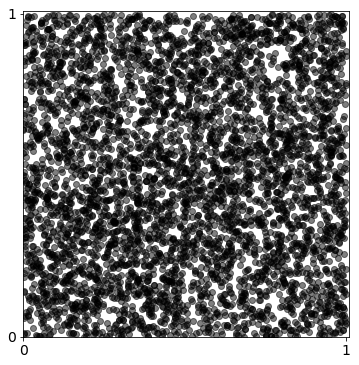

In [62]:
fig, ax = plt.subplots()
ax.set_aspect('equal');

ax.scatter(x, y, c='k', alpha=0.5);

ax.set_xticks([0, 1]);
ax.set_xlim(0, 1.01);

ax.set_yticks([0, 1]);
ax.set_ylim(0, 1.01);

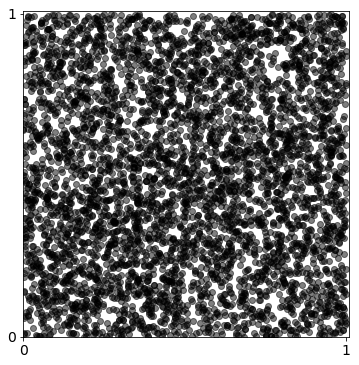

In [63]:
fig

En comptant le nombre de point qui tombent dans le quatier de cercle de rayon 1, on obtient une approximation de l'aire dans de quartier de cercle, qui est en réalité de $\frac{\pi}{4}$.

In [64]:
in_circle = x**2 + y**2 <= 1

In [65]:
fig, ax = plt.subplots()
ax.set_aspect('equal');

x_plot = np.linspace(0, 1, 100)
ax.plot(x_plot, np.sqrt(1 - x_plot**2), c='k');

ax.scatter(x[in_circle], y[in_circle], c=green, alpha=0.5);
ax.scatter(x[~in_circle], y[~in_circle], c=red, alpha=0.5);

ax.set_xticks([0, 1]);
ax.set_xlim(0, 1.01);

ax.set_yticks([0, 1]);
ax.set_ylim(0, 1.01);

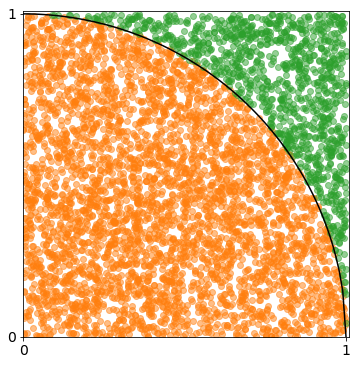

In [20]:
fig

Comme on s'y attend, 4 fois l'approximation du quart de l'air donne près de $\pi$. Plus d'échantillions donnerais une meilleur approximation

In [21]:
4 * in_circle.mean()

3.1343999999999999

#### Historique des méthodes de Monte Carlo

<center><img src="http://www.bgu.ac.il/~oaharon/feynman/Feynman_Portraits_files/Ulam_Feynman_von_Neumann.jpg"></center>

Les méthodes de Monte Carlo ont été largement utilisées pour le [Projet Manhattan](https://en.wikipedia.org/wiki/Monte_Carlo_method#Definitions).  Sur la photo ci-dessus, on voit des scientifiques du projet Manhattan [Stanislaw_Ulam](https://en.wikipedia.org/wiki/Stanislaw_Ulam),[Richard Feynman](https://en.wikipedia.org/wiki/Richard_Feynman) et [John von Neumann](https://en.wikipedia.org/wiki/John_von_Neumann). En travaillant sur le projet Manhattan, Ulam a donné l'une des premières descriptions des algorithmes des [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Monte_Carlo). La librairie de programmation probabiliste [Stan](http://mc-stan.org/) est nommé en son honneur.

## Le problème de Monty Hall

<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Monty_open_door.svg/640px-Monty_open_door.svg.png' width="45%"></center>

Le [problème de Monty Hall](https://en.wikipedia.org/wiki/Monty_Hall_problem) est un célèbre puzzle de probabilité, basé sur l'émission de jeux des années 1960 [Let's Make a Deal](https://en.wikipedia.org/wiki/Let%27s_Make_a_Deal) et nommé d'après son hôte d'origine. Dans le jeu, un concurrent se voyait présenter trois portes, dont deux contenaient un article de peu ou pas de valeur (par exemple, une chèvre) et l'une d'entre elles contenait un article de très grande valeur (par exemple, une voiture de luxe). Le concurrent devait d'abord deviner quelle porte contenait la voiture de sport. Après la devinette initiale du concurrent, Monty ouvrait l'une des deux autres portes, révélant une chèvre. Monty offrait alors au concurrent la chance de changer leur choix de porte. Le problème de Monty Hall pose la question suivante : le candidat doit-il conserver son choix initial de porte ou le changer ?



Au départ, nous n'avons aucune information sur la porte derrière laquelle se trouve le prix.

In [22]:
with pm.Model() as monty_model:
    prize = pm.DiscreteUniform('prize', 0, 2)

Si nous choisisson la porte 1:

<table>
    <tr>
        <td></td>
        <th colspan="3"><center>Monty peut ouvrir</center></th>
    </tr>
    <tr>
        <th>Prix derrière</th>
        <td>Porte 1</td>
        <td>Porte 2</td>
        <td>Porte 3</td>
    </tr>
    <tr>
        <td>Porte 1</td>
        <td><font color="red">Non</font></td>
        <td><font color="green">Oui</font></td>
        <td><font color="green">Oui</font></td>
    </tr>
    <tr>
        <td>Porte 2</td>
        <td><font color="red">Non</font></td>
        <td><font color="red">Non</font></td>
        <td><font color="green">Oui</font></td>
    </tr>
    <tr>
        <td>Porte 3</td>
        <td><font color="red">Non</font></td>
        <td><font color="green">Oui</font></td>
        <td><font color="red">Non</font></td>
    </tr>
</table>

In [23]:
from theano import tensor as tt

with monty_model:
    # Probability that Monty open each door
    p_open = pm.Deterministic('p_open',
                              tt.switch(tt.eq(prize, 0),
                                        # it is behind the first door
                                        np.array([0., 0.5, 0.5]),
                              tt.switch(tt.eq(prize, 1),
                                        # it is behind the second door
                                        np.array([0., 0., 1.]),
                                        # it is behind the third door
                                        np.array([0., 1., 0.]))))

Monty ouvre la porte 3 contenant une chèvre

<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Monty_open_door.svg/640px-Monty_open_door.svg.png'></center>

In [24]:
with monty_model:
    opened = pm.Categorical('opened', p_open, observed=2)

Doit-on changer de porte?

In [25]:
with monty_model:
    monty_trace = pm.sample(draws=10000, random_seed=SEED)
    
monty_df = pm.trace_to_dataframe(monty_trace)

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [prize]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:03<00:00, 5418.35draws/s]
The number of effective samples is smaller than 25% for some parameters.


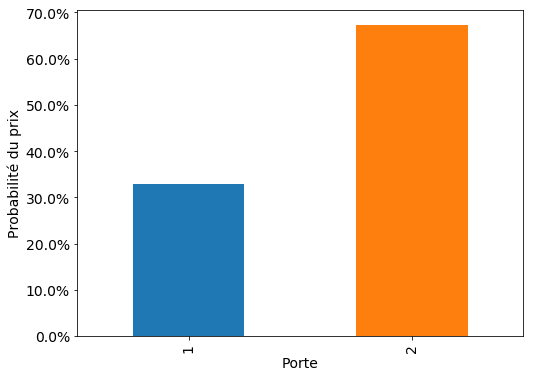

In [82]:
fig, ax = plt.subplots(figsize=(8, 6))

ax = (monty_df.groupby('prize')
              .size()
              .div(monty_df.shape[0])
              .plot(kind='bar', ax=ax))

ax.set_xlabel("Porte");
ax.set_xticklabels([1, 2])
ax.yaxis.set_major_formatter(pct_formatter);
ax.set_ylabel("Probabilité du prix");

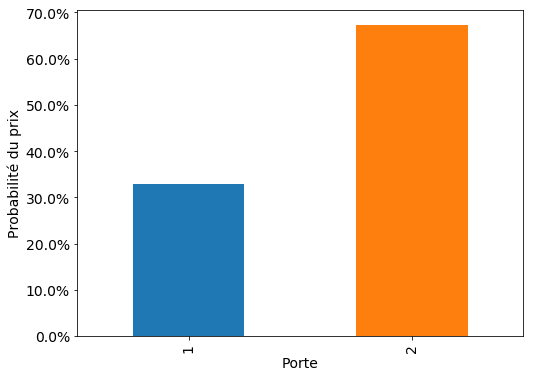

In [83]:
fig

Donc, oui on devrait changer de porte

**En option**

We can also resolve the Monty Hall problem with pen and paper, as follows.

Throughout this calculation, all probabilities assume that we have initially chosen the first door.  By Bayes' Theorem, the probability that the sportscar is behind door one given that Monty opened door three is

$$P(\textrm{Behind door one}\ |\ \textrm{Opened door three}) = \frac{P(\textrm{Opened door three}\ |\ \textrm{Behind door one})P(\textrm{Behind door one})}{P(\textrm{Opened door three})}.$$

The a priori probability that the prize is behind any of the doors is one third.  From the table above, $P(\textrm{Opened door three}\ |\ \textrm{Behind door one}) = \frac{1}{2}$.  We calculate $P(\textrm{Opened door three})$ using the law of total probability as follows:

$$
\begin{align*}
P(\textrm{Opened door three})
    & = P(\textrm{Opened door three}\ |\ \textrm{Behind door one})P(\textrm{Behind door one}) \\
    & + P(\textrm{Opened door three}\ |\ \textrm{Behind door two})P(\textrm{Behind door two}) \\
    & + P(\textrm{Opened door three}\ |\ \textrm{Behind door three})P(\textrm{Behind door three}) \\
    & = \frac{1}{2} \cdot \frac{1}{3} + 1 \cdot \frac{1}{3} + 0 \cdot \frac{1}{3} \\
    & = \frac{1}{2}.
\end{align*}
$$

Therefore

$$
\begin{align*}
P(\textrm{Behind door one}\ |\ \textrm{Opened door three})
    & = \frac{P(\textrm{Opened door three}\ |\ \textrm{Behind door one})P(\textrm{Behind door one})}{P(\textrm{Opened door three})} \\
    & = \frac{\frac{1}{2} \cdot \frac{1}{3}}{\frac{1}{3}} \\
    & = \frac{1}{3}.
\end{align*}$$

Since $P(\textrm{Behind door three}\ |\ \textrm{Opened door three}) = 0$, because Monty wants the contestant's choice to be suspensful, $P(\textrm{Behind door two}\ |\ \textrm{Opened door three}) = \frac{2}{3}$.  Therefore it is correct to switch doors, confirming our computational results.

## Introduction à PyMC3

<center><img src='https://raw.githubusercontent.com/pymc-devs/pymc3/master/docs/pymc3_logo.jpg'></center>

De la [Documentation de PyMC3](http://pymc-devs.github.io/pymc3/):

> PyMC3 is a Python package for Bayesian statistical modeling and Probabilistic Machine Learning which focuses on advanced Markov chain Monte Carlo and variational fitting algorithms. Its flexibility and extensibility make it applicable to a large suite of problems.

[![License](https://img.shields.io/badge/License-Apache%202.0-blue.svg)](https://opensource.org/licenses/Apache-2.0)

## Étude de cas: Sleep Deprivation

<center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5c/%22Plenty_of_sleep_keeps_him_on_the_job%22_-_NARA_-_514792.jpg/1280px-%22Plenty_of_sleep_keeps_him_on_the_job%22_-_NARA_-_514792.jpg" width=300></center>

Les données proviennent de la librairie [`lme4`](https://cran.r-project.org/web/packages/lme4/) du language R, qui cite 

Gregory Belenky, Nancy J. Wesensten, David R. Thorne, Maria L. Thomas, Helen C. Sing, Daniel P. Redmond, Michael B. Russo and Thomas J. Balkin (2003) Patterns of performance degradation and restoration during sleep restriction and subsequent recovery: a sleep dose-response study. _Journal of Sleep Research_ 12, 1–12.

In [29]:
sleep_df = (get_rdataset('sleepstudy', 'lme4', cache=True)
                .data
                .rename(columns=str.lower)
                .assign(reaction_std=lambda df: (df.reaction - df.reaction.mean()) / df.reaction.std()))

In [30]:
sleep_df.head()

,reaction,days,subject,reaction_std
0,249.5600,0,308,-0.868968
1,258.7047,1,308,-0.706623
2,250.8006,2,308,-0.846944
3,321.4398,3,308,0.407108
4,356.8519,4,308,1.035777


Dans cette étude, chacun des sujets obtient son temps normal de sommeil lors du premier jour.  Leur temps de sommeil est réduit à 3 heures pour les journées subséquentes.  La colonne`reaction` est leur temps de réponse moyen à un nombre de tests.  La colonne `reaction_std` est le résultat de la [standardisation](https://en.wikipedia.org/wiki/Standard_score) (Z-score) `reaction` sur tous les sujets et tous les jours.

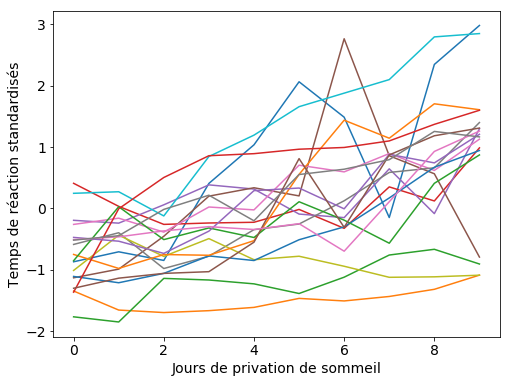

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))

(sleep_df.groupby('subject')
         .plot('days', 'reaction_std',
               ax=ax, legend=False));

ax.set_xlabel("Jours de privation de sommeil");
ax.set_ylabel("Temps de réaction standardisés");

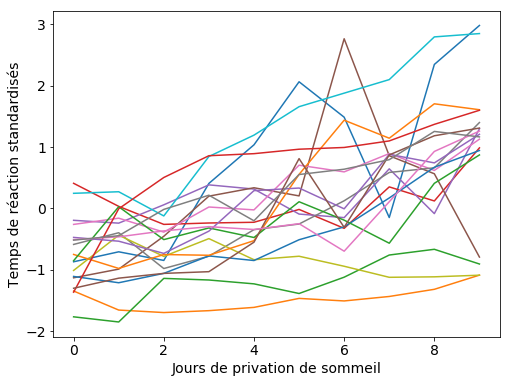

In [32]:
fig

We translate the subject ids in `sleep_df`, which start at 308, to begin at zero and increase sequentially.

In [33]:
subject_ix, subject_map = sleep_df.subject.factorize()
n_subjects = subject_map.size

days = sleep_df.days.values
reaction_std = sleep_df.reaction_std.values

Chaque sujet devrait avoir un temps de réaction de base qui ne devrait pas trop différer les uns des autres

In [34]:
with pm.Model() as sleep_model:
    μ_α = pm.Normal('μ_α', 0., 5.)
    σ_α = pm.HalfCauchy('σ_α', 5.)
    α = pm.Normal('α', μ_α, σ_α, shape=n_subjects)

Le taux de croissance des temps de réponse en fonction du nombre de jours de privation de sommeil différe selon chacun des sujets.

In [35]:
with sleep_model:
    μ_β = pm.Normal('μ_β', 0., 5.)
    σ_β = pm.HalfCauchy('σ_β', 5.)
    β = pm.Normal('β', μ_β, σ_β, shape=n_subjects)

La combinaison du temps de réponse de base et du taux de croissance correspondent à nos observations.

In [36]:
with sleep_model:
    μ = pm.Deterministic('μ', α[subject_ix] + β[subject_ix] * days)
    σ = pm.HalfCauchy('σ', 5.)
    obs = pm.Normal('obs', μ, σ, observed=reaction_std)

Ce type de model est connu sous le nom de model linéaire hiérarchique (mixe) "hierarchical (or mixed) linear model", parce que il permet à la pente et à la valeur initiale de variée selon le sujet, mais ajoute un terme de régularisation grâce à un apriori partagé par les sujets. Pour plus d'informations lire Gelman and Hill [_Data Analysis Using Regression and Multilevel/Hierarchical Models_](http://www.stat.columbia.edu/~gelman/arm/).

In [37]:
N_JOBS = 3
JOB_SEEDS = [SEED + i for i in range(N_JOBS)]

with sleep_model:
    sleep_trace = pm.sample(njobs=N_JOBS, random_seed=JOB_SEEDS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [σ, β, σ_β, μ_β, α, σ_α, μ_α]
Sampling 3 chains: 100%|██████████| 3000/3000 [00:06<00:00, 479.65draws/s]


### Diagnostic de la convergence

PyMC3 met à disposition une suite d'outils de diagnostic de convergence [statistcal convergence diagnostics](http://pymc-devs.github.io/pymc3/api/stats.html) pour s'assurer que les échantillions soient une bonne approximation de la vrai distribution postérieure.

Les tracés d'énergie et la fraction bayésienne d'informations manquantes (BFMI) sont deux diagnostics pertinents pour l'échantillonnage Monte Carlo Hamiltonien, que nous avons utilisé dans cet exemple.  Si les deux distributions dans le tracé d'énergie diffèrent de façon significative (surtout dans les queues), l'échantillonnage n'a pas été très efficace.  La fraction bayésienne des informations manquantes quantifie cette différence avec un nombre compris entre zéro et un.  Un BFMI proche de 1 est préférable, et un BFMI inférieur à 0,2 indique des problèmes d'efficacité.

Pour plus d'information : Michael Betancourt [_A Conceptual Introduction to Hamiltonian Monte Carlo_](https://arxiv.org/abs/1701.02434) et [_Robust Statistical Workflow with PyStan_](http://mc-stan.org/users/documentation/case-studies/pystan_workflow.html).

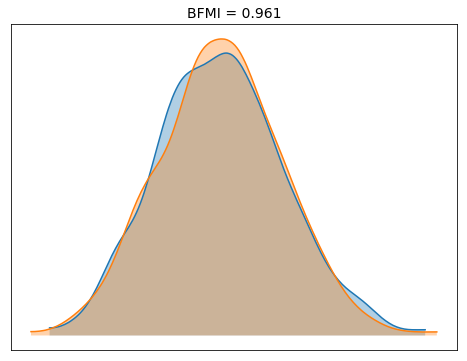

In [38]:
ax = pm.energyplot(sleep_trace, legend=False)
ax.set_title("BFMI = {:.3f}".format(pm.bfmi(sleep_trace)));

Contrairement aux tracés énergétiques et aux BFMI, qui sont spécifiques aux algorithmes de Monte Carlo Hamiltonien, la statistique [Gelman-Rubin](http://blog.stata.com/2016/05/26/gelman-rubin-convergence-diagnostic-using-multiple-chains/) est applicable à n'importe quel algorithme MCMC, à condition que plusieurs chaînes aient été échantillonnées.  Une statistique de Gelman-Rubin près de 1 est préférable, et les valeurs inférieures à 1,1 sont généralement considérées comme une indication de convergence.

In [39]:
max(np.max(gr_values) for gr_values in pm.gelman_rubin(sleep_trace).values())

1.0044401016760927

### Prediction

En inférence Bayesienne les prédictions sont effectuées en échantillionnant la [distribution postiérieur](https://en.wikipedia.org/wiki/Posterior_predictive_distribution), qui est la distribution des observations futures possibles sachant les observations antérieures.

In [40]:
with sleep_model:
    pp_sleep_trace = pm.sample_ppc(sleep_trace)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 500/500 [00:00<00:00, 931.09it/s]


We convert the posterior predictive samples to a `DataFrame`.

In [41]:
PP_DATA= {'pp_{}'.format(i):  pp_col for i, pp_col in enumerate(pp_sleep_trace['obs'])}
PP_COLS = list(PP_DATA.keys())

pp_df = sleep_df.assign(**PP_DATA)

In [42]:
pp_df.head()

,reaction,days,subject,reaction_std,pp_0,pp_1,pp_2,pp_3,pp_4,pp_5,...,pp_490,pp_491,pp_492,pp_493,pp_494,pp_495,pp_496,pp_497,pp_498,pp_499
0,249.5600,0,308,-0.868968,-0.480800,-0.079674,-2.205570,-0.330455,-0.768948,-0.627255,...,-1.472537,-1.425459,-1.743710,-1.481138,-1.012653,-0.373159,-1.621150,-0.012555,-0.411778,0.374063
1,258.7047,1,308,-0.706623,-0.370315,-0.629619,-0.814079,-0.066736,0.105850,-1.269730,...,-0.741041,-0.284471,-0.568688,-0.703413,-0.141564,-0.087318,-0.456277,-0.206847,-0.609137,0.088450
2,250.8006,2,308,-0.846944,-0.008628,-0.347479,-0.149224,-0.300898,-0.307267,-0.854495,...,-0.580852,-0.357487,0.111071,-0.062703,0.147286,0.671985,-0.111278,-0.377936,-0.126298,-0.082806
3,321.4398,3,308,0.407108,0.618591,-0.623723,-0.496155,-0.284997,0.697374,0.620396,...,0.604507,-0.082013,0.069937,0.419080,-0.352991,0.128228,0.116282,0.882189,-0.282886,0.936534
4,356.8519,4,308,1.035777,0.745061,0.399102,-0.369991,0.183814,0.883505,0.257296,...,0.725527,0.108129,0.675451,0.767041,0.231174,0.407171,0.852856,0.626381,0.066292,0.173902


In [43]:
def pp_subject_plot(pp_subject_df, ax):
    low = pp_subject_df[PP_COLS].quantile(0.025, axis=1)
    high = pp_subject_df[PP_COLS].quantile(0.975, axis=1)

    ax.fill_between(pp_subject_df.days, low, high,
                    color='k', alpha=0.25)

    ax.plot(pp_subject_df.days, pp_subject_df.reaction_std)
    ax.plot(pp_subject_df.days, pp_subject_df[PP_COLS].mean(axis=1),
            c='k');
    
def pp_subject_plot_helper(data=None, **_):
    pp_subject_plot(data, plt.gca())

The following plot shows the predicted and observed reaction times for each subjects.

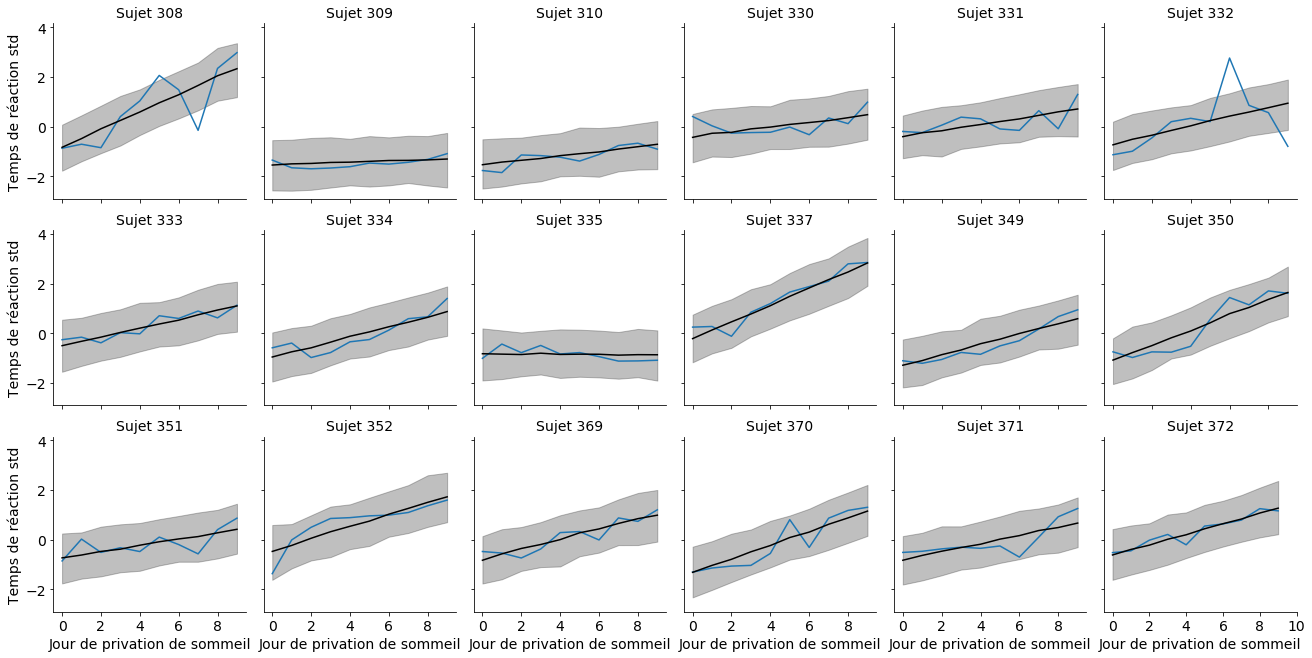

In [44]:
grid = sns.FacetGrid(pp_df, col='subject', col_wrap=n_subjects // 3)
grid.map_dataframe(pp_subject_plot_helper);

grid.set_axis_labels("Jour de privation de sommeil", "Temps de réaction std");
ax = plt.gca()
ax.set_xticks([0, 2, 4, 6, 8, 10])
grid.set_titles("Sujet {col_name}");

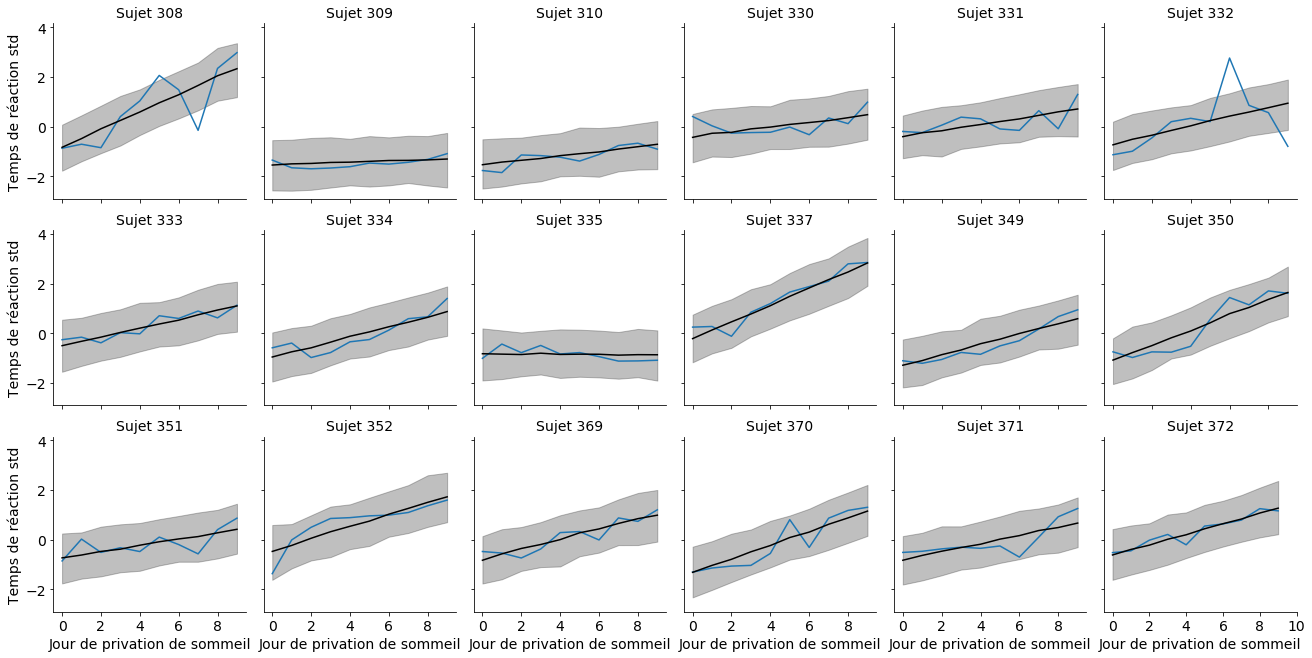

In [45]:
grid.fig

### Étude de cas: EEVEE

## Pour plus d'info

Les livres/répertoires GitHub suivants fournissent de bonnes introductions à PyMC3 et aux statistiques bayésiennes.

### Statistiques bayésiennes

<table>
    <tr>
        <td>
            <a href="https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers#pymc3"><img src="https://camo.githubusercontent.com/4a0aca82ca82efab71747d00db30f3a68de98e82/687474703a2f2f692e696d6775722e636f6d2f36444b596250622e706e673f31" width="300"></a>
            <br>
        </td>
        <td>
            <a href="https://bayesmodels.com/"><img src="https://images-na.ssl-images-amazon.com/images/I/51K33XI2I8L._SX330_BO1,204,203,200_.jpg " width="250"></a>
        </td>
        <td>
            <a href="https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3"><img src="http://xcelab.net/rm/wp-content/uploads/2012/01/9781482253443.jpg" width="250"></a>
        </td>
        <td>
            <a href="https://www.amazon.ca/Doing-Bayesian-Data-Analysis-Tutorial/dp/0124058884/ref=dp_ob_image_bk"><img src="https://images-na.ssl-images-amazon.com/images/I/51LLy0AWDpL._SX404_BO1,204,203,200_.jpg" width="250"></a>
        </td>
    </tr>
</table>

Plusieurs sont disponible à la bibliothèque ou en ligne avec [Ariane 2.0](http://arianeweb.ulaval.ca/ariane/wicket/accueil)

## Échosystème de programmation probabiliste

<table>
    <tr>
        <th>Probabilistic Programming System</th>
        <th>Language</th>
        <th>License</th>
        <th>Discrete Variable Support</th>
        <th>Automatic Differentiation/Hamiltonian Monte Carlo</th>
        <th>Variational Inference</th>
    </tr>
    <tr>
        <td><a href='http://pymc-devs.github.io/pymc3/'>PyMC3</a></td>
        <td>Python</td>
        <td>Apache V2</td>
        <td><font color="green">Yes</font></td>
        <td><font color="green">Yes</font></td>
        <td><font color="green">Yes</font></td>
    </tr>
    <tr>
        <td><a href='http://mc-stan.org/'>Stan</a></td>
        <td>C++, R, Python, ...</td>
        <td>BSD 3-clause</td>
        <td><font color="red">No</font></td>
        <td><font color="green">Yes</font></td>
        <td><font color="green">Yes</font></td>
    </tr>
    <tr>
        <td><a href="http://edwardlib.org/">Edward</a></td>
        <td>Python, ...</td>
        <td>Apache V2</td>
        <td><font color="green">Yes</font></td>
        <td><font color="green">Yes</font></td>
        <td><font color="green">Yes</font></td>
    </tr>
    <tr>
        <td><a href='http://www.mrc-bsu.cam.ac.uk/software/bugs/'>BUGS</a></td>
        <td>Standalone program, R</td>
        <td>GPL V2</td>
        <td><font color="green">Yes</font></td>
        <td><font color="red">No</font></td>
        <td><font color="red">No</font></td>
    </tr>
    <tr>
        <td><a href='chrome-extension://ojhmphdkpgbibohbnpbfiefkgieacjmh/app/index.html'>JAGS</a></td>
        <td>Standalone program, R</td>
        <td>GPL V2</td>
        <td><font color="green">Yes</font></td>
        <td><font color="red">No</font></td>
        <td><font color="red">No</font></td>
    </tr>
</table>

## Merci!


Le Jupyter notebook utilisé pour ces transparents est disponible [ici](https://gist.github.com/alexisfcote/c3751e0771c42eeb9706989819c6d0c8) ou https://gist.github.com/alexisfcote/.

In [26]:
!jupyter nbconvert --to=slides --reveal-prefix=https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.2.0/ --output=pymc3-Basian-Inference "pymc3-Basian-Inference.ipynb"

[NbConvertApp] Converting notebook pymc3-Basian-Inference.ipynb to slides
[NbConvertApp] Writing 1114540 bytes to pymc3-Basian-Inference.slides.html
